In [105]:
from google.cloud import bigquery

import pandas as pd
import pandas_gbq
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from math import ceil
import re

In [2]:
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
trigger_mvideo = pd.read_excel('Таблица Триггеры мвидео.xlsx', sheet_name='Sheet 1')
trigger_eldo = pd.read_excel('Таблица Триггеры eldo.xlsx', sheet_name='Sheet 1')
trigger_eldo_ios = pd.read_excel('Таблица Триггеры eldo_ios.xlsx', sheet_name='Sheet 1')
trigger_mvideo_ios = pd.read_excel('Таблица Триггеры mvideo_ios.xlsx', sheet_name='Sheet 1')
trigger_eldo_andr = pd.read_excel('Таблица Триггеры eldo_andr.xlsx', sheet_name='Sheet 1')
trigger_mvideo_andr = pd.read_excel('Таблица Триггеры mvideo_andr.xlsx', sheet_name='Sheet 1')

trigger_mvideo_andr['Название рассылки'] = trigger_mvideo_andr['Название рассылки'].apply(lambda x: x.replace('Android', 'xx')).apply(lambda x: x.replace('android', 'xx'))
trigger_mvideo_ios['Название рассылки'] = trigger_mvideo_ios['Название рассылки'].apply(lambda x: x.replace('iOS', 'xx')).apply(lambda x: x.replace('IOS', 'xx'))
trigger_eldo_andr['Название рассылки'] = trigger_eldo_andr['Название рассылки'].apply(lambda x: x.replace('Android', 'xx')).apply(lambda x: x.replace('android', 'xx'))
trigger_eldo_ios['Название рассылки'] = trigger_eldo_ios['Название рассылки'].apply(lambda x: x.replace('iOS', 'xx')).apply(lambda x: x.replace('IOS', 'xx'))

In [ ]:
def get_params(df, group):
    
    scenarium = []
    for i, n in enumerate(df['Сценарий'].to_list()):
        if type(n) == float:
            scenarium.append(scenarium[i - 1])
        else:
            scenarium.append(n)

    df['Сценарий'] = scenarium
    
    res_df = df.groupby(by=group, as_index=False).agg({'Отправлено': 'sum', 
                                                            'Доставлено': 'sum',
                                                            'Клики': 'sum',
                                                            'Сеансы': 'sum',
                                                            'Заказы': 'sum',
                                                            'Оборот заказов': 'sum'})

    res_df['delivery_rate'] = res_df['Доставлено'] *100 / res_df['Отправлено']
    res_df['CTR'] = res_df['Клики'] * 100 / res_df['Доставлено']
    res_df['session_rate'] = res_df['Сеансы'] * 100 / res_df['Доставлено']
    res_df['session_rate_click'] = res_df['Сеансы'] * 100 / res_df['Клики']
    res_df['CR_deliv'] = res_df['Заказы'] * 100 / res_df['Доставлено']
    res_df['CR_click'] = res_df['Заказы'] * 100 / res_df['Клики']
    res_df['AOV'] = res_df['Оборот заказов'] / res_df['Заказы']
    res_df['ARPCU'] = res_df['Оборот заказов'] / res_df['Клики']
    res_df['ARPU'] = res_df['Оборот заказов'] / res_df['Доставлено']
    
    return res_df

In [ ]:
params_mvideo = get_params(trigger_mvideo, group='Сценарий')
params_eldo = get_params(trigger_eldo, group='Сценарий')
params_eldo_ios = get_params(trigger_eldo_ios, group='Название рассылки')
params_mvideo_ios = get_params(trigger_mvideo_ios, group='Название рассылки')
params_eldo_andr = get_params(trigger_eldo_andr, group='Название рассылки')
params_mvideo_andr = get_params(trigger_mvideo_andr, group='Сценарий')

In [ ]:
params_eldo_ios[params_eldo_ios['Сценарий'] != 'Total'].sort_values(by='Доставлено', ascending=False).to_excel('eldo.xlsx')

In [ ]:
((params_eldo_andr[params_eldo_andr != 'Эльдорадо'].sort_values(by='Сценарий', ascending=False)['CTR'] 
 - params_eldo_ios.sort_values(by='Сценарий', ascending=False)['CTR']) * 100 
 / params_eldo_andr[params_eldo_andr != 'Эльдорадо'].sort_values(by='Сценарий', ascending=False)['CTR'])

In [ ]:
merged = params_eldo_andr.merge(params_eldo_ios, on='Название рассылки')
merged['CTR_diff'] = (merged['CTR_x']- merged['CTR_y']) * 100 / merged['CTR_x']
merged['session_rate_diff'] = (merged['session_rate_x']- merged['session_rate_y']) * 100 / merged['session_rate_x']
merged['session_rate_click_diff'] = (merged['session_rate_click_x']- merged['session_rate_click_y']) * 100 / merged['session_rate_click_x']
merged['CR_diff'] = (merged['CR_deliv_x']- merged['CR_deliv_y']) * 100 / merged['CR_deliv_x']
merged['CR_click_diff'] = (merged['CR_click_x']- merged['CR_click_y']) * 100 / merged['CR_click_x']
merged['AOV_diff'] = (merged['AOV_x']- merged['AOV_y']) * 100 / merged['AOV_x']
merged['ARPU_diff'] = (merged['ARPU_x']- merged['ARPU_y']) * 100 / merged['ARPU_x']
merged['ARPCU_diff'] = (merged['ARPCU_x']- merged['ARPCU_y']) * 100 / merged['ARPCU_x']

merged[['Название рассылки', 'CTR_diff', 'session_rate_diff', 'session_rate_click_diff', 'CR_diff'
       , 'CR_click_diff', 'AOV_diff', 'ARPU_diff', 'ARPCU_diff', 'Доставлено_x']].sort_values(by='CTR_diff', ascending=False)\
        .to_excel('eldo_diff.xlsx')

In [ ]:
trigger_mvideo_andr['Название рассылки'].apply(lambda x: x.replace('Android', 'xx')).apply(lambda x: x.replace('android', 'xx'))
trigger_eldo_andr['Название рассылки'].apply(lambda x: x.replace('iOS', 'xx')).apply(lambda x: x.replace('IOS', 'xx'))

In [ ]:
params_mvideo_ios.sort_values(by='CTR', ascending=False).to_excel('mvid_ios.xlsx')

In [ ]:
import re

In [ ]:
word_analisys = pd.read_csv('Messaging summary report.csv', sep=';')
# word_analisys.template = word_analisys.template.apply(lambda x: x.lower().split(' '))
word_analisys.template = word_analisys.template.apply(lambda x: re.findall(r'[а-я]+', x.lower()))
word_analisys = word_analisys[word_analisys.template.apply(lambda x: len(x)) > 0]
word_analisys = word_analisys.explode('template')\
.groupby(by='template', as_index=False)\
.agg({'delivered': 'sum','clicked': 'sum', 'conversions': 'sum' })\
.reset_index(drop=True)
word_analisys['CTR'] = word_analisys['clicked'] * 100 / word_analisys['delivered']
word_analisys['CR'] = word_analisys['conversions'] * 100 / word_analisys['delivered']

word_analisys[word_analisys.template.apply(lambda x: len(x)) > 4][word_analisys.delivered > 500000]\
.sort_values(by='CTR', ascending=False).to_excel('mvideo_words.xlsx')#.drop_duplicates(keep='last', subset='clicked')
# word_analisys

In [ ]:
word_analisys = pd.read_csv('Messaging summary report.csv', sep=';')
# word_analisys.template = word_analisys.template.apply(lambda x: x.lower().split(' '))
word_analisys.subject = word_analisys.subject.apply(lambda x: re.findall(r'[а-я]+', x.lower()))
word_analisys = word_analisys[word_analisys.subject.apply(lambda x: len(x)) > 0]
word_analisys = word_analisys.explode('subject')
word_analisys.subject = word_analisys.subject.apply(lambda x: x[:4]) 
word_analisys = word_analisys\
.groupby(by='subject', as_index=False)\
.agg({'delivered': 'sum','clicked': 'sum', 'conversions': 'sum' })\
.reset_index(drop=True)
word_analisys['CTR'] = word_analisys['clicked'] * 100 / word_analisys['delivered']
word_analisys['CR'] = word_analisys['conversions'] * 100 / word_analisys['delivered']

word_analisys[word_analisys.subject.apply(lambda x: len(x)) >= 4][word_analisys.delivered > 1500000]\
.sort_values(by='CTR', ascending=False).to_excel('mvideo_sub.xlsx')#.drop_duplicates(keep='last', subset='clicked')
# word_analisys

In [ ]:
word_analisys = pd.read_csv('eldo words.csv', sep=';')
# word_analisys.template = word_analisys.template.apply(lambda x: x.lower().split(' '))
word_analisys.template = word_analisys.template.apply(lambda x: re.findall(r'[а-я]+', x.lower()))
word_analisys = word_analisys[word_analisys.template.apply(lambda x: len(x)) > 0]
word_analisys = word_analisys.explode('template')\
.groupby(by='template', as_index=False)\
.agg({'delivered': 'sum','clicked': 'sum', 'conversions': 'sum' })\
.reset_index(drop=True)
word_analisys['CTR'] = word_analisys['clicked'] * 100 / word_analisys['delivered']
word_analisys['CR'] = word_analisys['conversions'] * 100 / word_analisys['delivered']

word_analisys[word_analisys.template.apply(lambda x: len(x)) > 4][word_analisys.delivered > 500000]\
.sort_values(by='CTR', ascending=False).to_excel('eldo_words.xlsx')#.drop_duplicates(keep='last', subset='clicked')
# word_analisys

In [ ]:
word_analisys = pd.read_csv('eldo words.csv', sep=';')
# word_analisys.template = word_analisys.template.apply(lambda x: x.lower().split(' '))
word_analisys.subject = word_analisys.subject.apply(lambda x: re.findall(r'[а-я]+', x.lower()))
word_analisys = word_analisys[word_analisys.subject.apply(lambda x: len(x)) > 0]
word_analisys = word_analisys.explode('subject')
word_analisys.subject = word_analisys.subject.apply(lambda x: x[:4]) 
word_analisys = word_analisys\
.groupby(by='subject', as_index=False)\
.agg({'delivered': 'sum','clicked': 'sum', 'conversions': 'sum' })\
.reset_index(drop=True)
word_analisys['CTR'] = word_analisys['clicked'] * 100 / word_analisys['delivered']
word_analisys['CR'] = word_analisys['conversions'] * 100 / word_analisys['delivered']

word_analisys[word_analisys.subject.apply(lambda x: len(x)) >= 4][word_analisys.delivered > 1500000]\
.sort_values(by='CTR', ascending=False).to_excel('eldo_sub.xlsx')#.drop_duplicates(keep='last', subset='clicked')
# word_analisys

# Ядро

### Обработка DF

In [130]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf


from math import ceil
import re
import warnings
warnings.filterwarnings('ignore')

In [157]:
def analyse_text(df, text_col):
    
    res_df = pd.DataFrame()
    
    res_df['text'] = df[text_col]\
                    .apply(lambda x: re.sub(r'@{if IsEmpty\(Recipient\.OnlyStandardFirstName\)}.*?@{else}\s?\${Recipient\.OnlyStandardFirstName\s*}', 'Александр', x))\
                    .apply(lambda x: x.replace('@{end if}', ''))
    # символы и смайлики в тексте 
    res_df['text_graphic_symbols'] =  res_df['text']\
    .apply(lambda x: re.findall(r'[^\w\s\d%!-.,?—₽ ️{, }@––> ‍−−…=]', x.lower()))
    # кол-во доставленных сообщений
    res_df['delivered'] = df['delivered']
    # кол-во кликов
    res_df['clicked'] = df['clicked']
    # кол-во буквенных символов в заголовке
    res_df['alphabet_symbols_len'] = res_df['text']\
    .apply(lambda x: re.findall(r'[a-zа-я]+', x.lower()))\
    .apply(lambda x: sum(len(element) for element in x))
    # общее кол-во символов
    res_df['total_symbols_len'] = res_df['text']\
    .apply(lambda x: len(x))
    # кол-во слов
    res_df['alphabet_words_len'] = res_df['text']\
    .apply(lambda x: re.findall(r'[a-zа-я0-9]{3,}', x.lower()))\
    .apply(lambda x: len(x))
    # поиск смайликов и графики
    res_df['graphic_symbols_len'] = res_df['text']\
    .apply(lambda x: re.findall(r'[^\w\s\d%!-.,?—₽ ️{, }@––> ‍−−…=]', x.lower())).apply(lambda x: len(x))
    res_df['CTR'] = round(res_df['clicked']*100/res_df['delivered'], 2)
    
    return res_df


def assign_percentile(x, df, split_by, split_bin):
    percentiles = df[split_by].quantile(np.arange(0.0, 1.0005, split_bin))
    perc = percentiles.to_list()
    prev_element = None
    for i in percentiles:
        if x <= percentiles.min():
            return f'{round(percentiles.min(), 2)}-{round(perc[1], 2)}'
        elif x >= percentiles.max():
            return f'{round(perc[-2], 2)}-{round(percentiles.max(), 2)}'
        elif (prev_element is not None) and (x <= i):
            return f"{round(prev_element, 2)}-{round(i, 2)}"
        prev_element = i


def agregate_factor(df, groupping_col:str, split_by=False, split_bin=False):
    
    res_df = df.groupby(by=groupping_col, as_index=False)\
               .agg({'delivered': 'sum', 'clicked': 'sum'})
    res_df['CTR'] = round(res_df['clicked']*100/res_df['delivered'], 2)
    res_df = res_df.sort_values(by='CTR', ascending=False).reset_index(drop=True)
    res_df = res_df[res_df.delivered > 50000].reset_index(drop=True)
    
    if split_by:
        res_df['interval'] = res_df[split_by].apply(lambda x: assign_percentile(x, df=res_df, split_by=split_by, split_bin=split_bin))
        res_df = res_df.groupby(by='interval', as_index=False).agg({'delivered': 'sum', 'clicked': 'sum'})
        res_df['CTR'] = round(res_df['clicked']*100/res_df['delivered'], 2)
        res_df = res_df.sort_values(by='CTR', ascending=False).reset_index(drop=True)
        res_df['mean_of_interval'] = res_df.interval.apply(lambda x: x.split('-'))\
                                           .apply(lambda x: list(map(lambda i: float(i), x)))\
                                           .apply(lambda x: round(np.mean(x), 2))
    return res_df


def corr_test(df, dep_var:str, indep_vars=None):
    if (indep_vars is None) & (type(dep_var) == str):
        indep_vars = list(filter(lambda column: column != dep_var, regimes._get_numeric_data().columns.to_list()))
    elif (indep_vars is None) & (type(dep_var) != str):
        indep_vars = list(filter(lambda column: column != dep_var.name, regimes._get_numeric_data().columns.to_list()))
    elif (type(indep_vars) != list) & (type(indep_vars) != str):
        indep_vars = indep_vars.columns.to_list()
    elif type(indep_vars) == str:
        lst = []
        lst.append(indep_vars)
        indep_vars = lst
    if type(dep_var) == str:
        dep_var = df[dep_var]
    corr_df = pd.DataFrame(index=indep_vars, columns=[['spearman_corr', 'spearman_sign', 'pearson_corr', 'pearson_sign', 'linear_corr', 'linear_sign']])
    for var in indep_vars:
        corr_df.loc[var, 'spearman_corr'] = round(ss.spearmanr(dep_var, df[var])[0], 2)
        corr_df.loc[var, 'spearman_sign'] = np.where(ss.spearmanr(dep_var, df[var])[1] < 0.05, 'significant', 'not significant')
        corr_df.loc[var, 'pearson_corr'] = round(ss.pearsonr(dep_var, df[var])[0], 2)
        corr_df.loc[var, 'pearson_sign'] = np.where(ss.pearsonr(dep_var, df[var])[1] < 0.05, 'significant', 'not significant')
        corr_df.loc[var, 'linear_corr'] = round(ss.linregress(dep_var, df[var])[2], 2)
        corr_df.loc[var, 'linear_sign'] = np.where(ss.linregress(dep_var, df[var])[3] < 0.05, 'significant', 'not significant')
    styled_corr_df = corr_df.style.applymap(lambda x: "background-color: pink" if x=='not significant' 
                                            else "background-color: white").format_index(lambda x: x[0], axis=1)
    return styled_corr_df

### Визуализация

In [187]:
# виз регрессии
def linear_visualization(df, dep_var:str, indep_vars=None):
    if (indep_vars is None) & (type(dep_var) == str):
        indep_vars = list(filter(lambda column: column != dep_var, regimes._get_numeric_data().columns.to_list()))
    elif (indep_vars is None) & (type(dep_var) != str):
        indep_vars = list(filter(lambda column: column != dep_var.name, regimes._get_numeric_data().columns.to_list()))
    elif (type(indep_vars) != list) & (type(indep_vars) != str):
        indep_vars = indep_vars.columns.to_list()
    elif type(indep_vars) == str:
        lst = []
        lst.append(indep_vars)
        indep_vars = lst
    if type(dep_var) == str:
        dep_var = df[dep_var]
    
    plt.figure(figsize=(15, 1.5*len(indep_vars)))
    for i, indep_var in enumerate(indep_vars):
        i += 1
        ax = plt.subplot(ceil(len(indep_vars)/3) , 3, i)
        sns.regplot(data=df, x=indep_var, y=dep_var)
        plt.xlabel(None)
        plt.ylabel(None)
        plt.grid(False)
        ax.set(yticklabels=[], xticklabels=[])
        plt.title('\n' + indep_var.capitalize().replace('_', ' '))

    plt.show()
    

def visualize_dep(df, group_by, dep_var='CTR', ploynom_degree=1):
    
    res_df = df.groupby(by=group_by, as_index=False).agg({'delivered': 'sum', 'clicked': 'sum'})
    res_df['CTR'] = round(res_df['clicked']*100/res_df['delivered'], 2)
    res_df = res_df[res_df.delivered > 50000]
    coefficients = np.polyfit(res_df[group_by].to_list(), res_df.CTR.to_list(), 1)
    res_df['y_regression'] = np.polyval(coefficients, res_df[group_by].to_list())
    res_df['point_colors'] = res_df['CTR'] - res_df['y_regression']
    res_df['point_colors'] = res_df['point_colors'].apply(lambda x: 'red' if x >= 0 else 'blue')
    
    plt.figure(figsize=(15, 6))
    plt.subplot(1 , 2, 1)
    sns.barplot(data=res_df, x=group_by, y=dep_var, palette=['lightgrey' if c == 'blue' else (1.0, 0.4, 0.4) for c in res_df['point_colors']])
    plt.grid(False)
    
    if ploynom_degree == 1:
        plt.subplot(1 , 2, 2)
        sns.regplot(data=res_df, x=group_by, y=dep_var, scatter=False)
        sns.scatterplot(data=res_df, x=group_by, y=dep_var, hue='point_colors', palette={'red': 'red', 'blue': 'blue'}, legend=False, s=100)
        plt.xlabel(None)
        plt.ylabel(None)
        plt.grid(False)
    else:
        coefficients = np.polyfit(res_df[group_by].to_list(), res_df.CTR.to_list(), ploynom_degree)
        res_df['y_regression'] = np.polyval(coefficients, res_df[group_by].to_list())
        plt.subplot(1 , 2, 2)
        sns.lineplot(data=res_df, x=group_by, y='y_regression')
        sns.scatterplot(data=res_df, x=group_by, y=dep_var, hue='point_colors', palette={'red': 'red', 'blue': 'blue'}, legend=False, s=100)
        plt.xlabel(None)
        plt.ylabel(None)
        plt.grid(False)
    plt.show()

## М.Видео (IOS) - массовые

### Заголовки

In [159]:
# читает csv
message_analysis_mvideo_ios = pd.read_csv('mvideo_ios_summary.csv', sep=';')

In [160]:
# анализирует заголовки
mvideo_header_analysis = analyse_text(message_analysis_mvideo_ios, 'subject')
mvideo_header_analysis

,text,text_graphic_symbols,delivered,clicked,alphabet_symbols_len,total_symbols_len,alphabet_words_len,graphic_symbols_len,CTR
0,Есть ещё 3 дня ⏰🔥,"[⏰, 🔥]",1820773,17499,9,17,2,2,0.96
1,Заберите подарок 🎁👉,"[🎁, 👉]",39401,1326,15,19,2,2,3.37
2,🏃💨Ноутбук без тормозов💻,"[🏃, 💨, 💻]",213555,5564,18,23,3,3,2.61
3,Встречай новинку 🆕🆕🆕,"[🆕, 🆕, 🆕]",381697,3524,15,20,2,3,0.92
4,👏−10 000 ₽ 👏 на 📱Xiaomi,"[👏, 👏, 📱]",190354,3334,8,23,2,3,1.75
...,...,...,...,...,...,...,...,...,...
526,Honor MagicBook 👨‍💻✨,"[👨, 💻, ✨]",63499,2885,14,20,2,3,4.54
527,−20 000 ₽ на ТВ 📺🎉,"[📺, 🎉]",72434,4596,4,18,1,2,6.35
528,📱Honor ещё выгоднее,[📱],343519,4606,15,19,2,1,1.34
529,До −50% для тебя 🏠,[🏠],63064,1061,9,18,2,1,1.68


__анализ по общему кол-ву символов__

In [161]:
corr_test(mvideo_header_analysis[mvideo_header_analysis.delivered > 50000], dep_var='CTR', 
          indep_vars=['alphabet_symbols_len', 'total_symbols_len',
                      'alphabet_words_len', 'graphic_symbols_len'])

,spearman_corr,spearman_sign,pearson_corr,pearson_sign,linear_corr,linear_sign
alphabet_symbols_len,-0.010000,not significant,-0.030000,not significant,-0.030000,not significant
total_symbols_len,0.110000,significant,0.090000,not significant,0.090000,not significant
alphabet_words_len,0.010000,not significant,0.010000,not significant,0.010000,not significant
graphic_symbols_len,0.010000,not significant,0.010000,not significant,0.010000,not significant


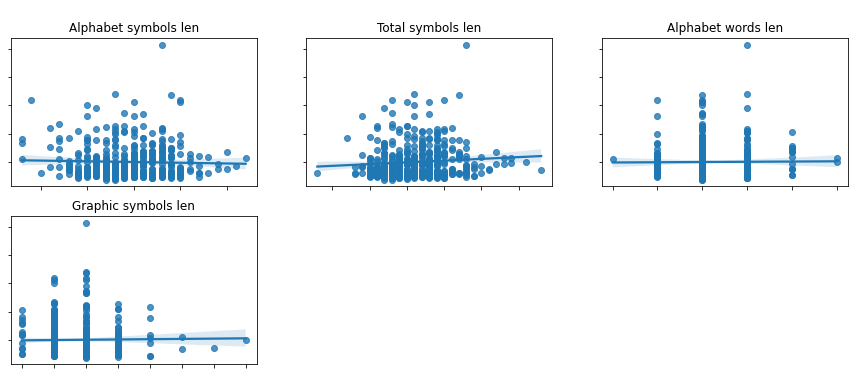

In [162]:
linear_visualization(mvideo_header_analysis[mvideo_header_analysis.delivered > 50000], dep_var='CTR', 
          indep_vars=['alphabet_symbols_len', 'total_symbols_len',
                      'alphabet_words_len', 'graphic_symbols_len'])

суммирую по кол-ву символов

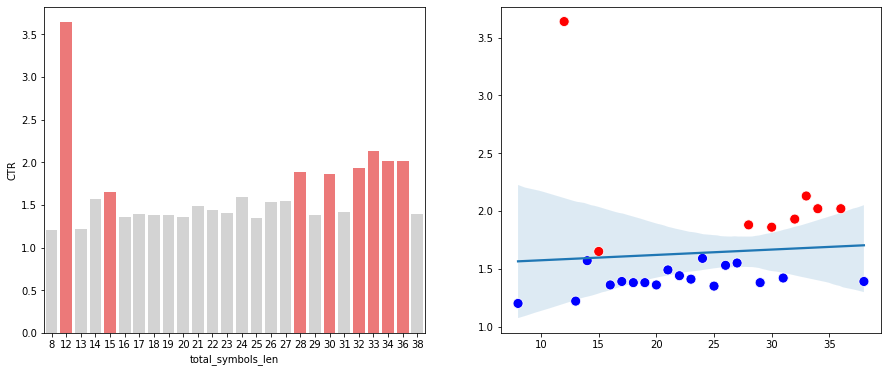

In [163]:
visualize_dep(mvideo_header_analysis, group_by='total_symbols_len')

укрупненная агрегация по интервалам

In [171]:
# агрегирует по общему кол-ву символов
agregated_by_total_symb = agregate_factor(mvideo_header_analysis, 'total_symbols_len', split_by='total_symbols_len', split_bin=0.08)
agregated_by_total_symb

,interval,delivered,clicked,CTR,mean_of_interval
0,31.0-33.0,3512991,72884,2.07,32.0
1,33.0-36.0,1795703,31044,1.73,34.5
2,29.0-31.0,6759656,115239,1.70,30.0
3,13.0-15.0,16659845,272620,1.64,14.0
4,27.0-29.0,16718787,273561,1.64,28.0
5,25.0-27.0,9021955,138979,1.54,26.0
6,23.0-25.0,53495855,807570,1.51,24.0
7,21.0-23.0,45592794,651607,1.43,22.0
8,19.0-21.0,61093533,863482,1.41,20.0
9,15.0-17.0,41906333,577156,1.38,16.0


In [165]:
# тест на корреляцию
corr_test(agregated_by_total_symb, dep_var='CTR', indep_vars='mean_of_interval')

,spearman_corr,spearman_sign,pearson_corr,pearson_sign,linear_corr,linear_sign
mean_of_interval,0.820000,significant,0.760000,significant,0.760000,significant


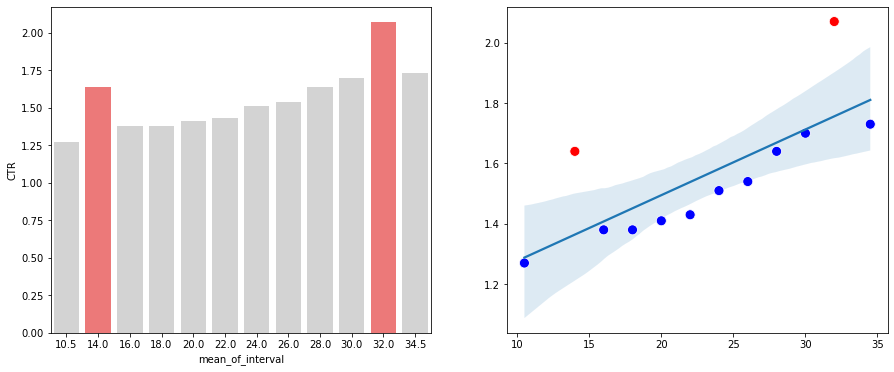

In [173]:
visualize_dep(agregated_by_total_symb, group_by='mean_of_interval')

In [176]:
# mvideo_header_analysis.query("13 < total_symbols_len <= 15")

__анализ по кол-ву алфавитных символов (букв)__

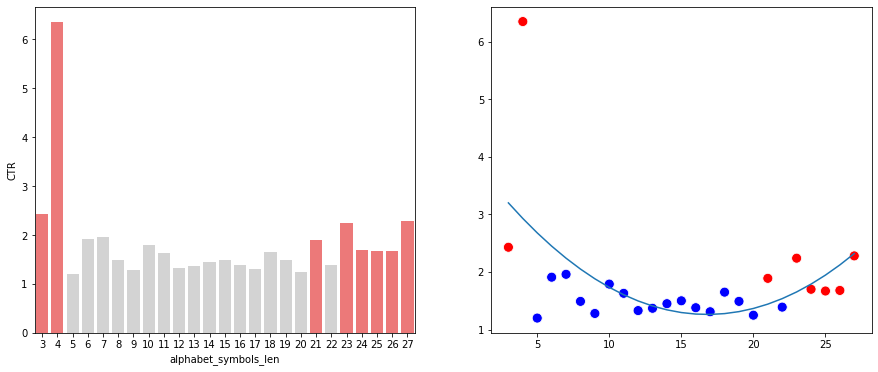

In [189]:
visualize_dep(mvideo_header_analysis, group_by='alphabet_symbols_len', ploynom_degree=2)

In [201]:
# агрегирует по общему кол-ву буквенных символов
agregated_by_alpha_symb = agregate_factor(mvideo_header_analysis, 'alphabet_symbols_len', split_by='alphabet_symbols_len', split_bin=0.08)
agregated_by_alpha_symb

,interval,delivered,clicked,CTR,mean_of_interval
0,3.0-4.92,1115525,29923,2.68,3.96
1,22.2-24.12,5709328,107720,1.89,23.16
2,4.92-6.84,1522500,26464,1.74,5.88
3,20.28-22.2,7635770,130078,1.70,21.24
4,24.12-26.04,2516289,42525,1.69,25.08
5,6.84-8.76,8928863,142562,1.60,7.80
6,8.76-10.68,24699556,378741,1.53,9.72
7,16.44-18.36,40788851,600252,1.47,17.40
8,14.52-16.44,55558068,800490,1.44,15.48
9,10.68-12.6,56629945,807137,1.43,11.64


In [202]:
# тест на корреляцию
corr_test(agregated_by_alpha_symb, dep_var='CTR', indep_vars='mean_of_interval')

,spearman_corr,spearman_sign,pearson_corr,pearson_sign,linear_corr,linear_sign
mean_of_interval,-0.130000,not significant,-0.330000,not significant,-0.330000,not significant


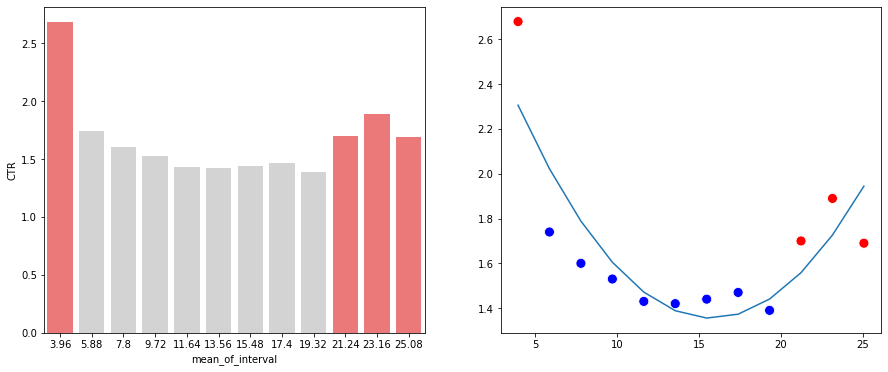

In [203]:
visualize_dep(agregated_by_alpha_symb, group_by='mean_of_interval', ploynom_degree=2)